In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Create folders to store CSVs if not exist
os.makedirs("raw_data", exist_ok=True)
os.makedirs("features", exist_ok=True)
os.makedirs("sector_data", exist_ok=True)

In [3]:
# List of tickers
tickers = ["AAPL", "ABBV", "ABT", "ACN", "ADBE", "AIG", "AMGN", "AMT", "AMZN", "AVGO",
    "AXP", "BA", "BAC", "BK", "BKNG", "BLK", "BMY", "C", "CAT",
    "CHTR", "CL", "CMCSA", "COF", "COP", "COST", "CRM", "CSCO", "CVS", "CVX",
    "DHR", "DIS", "DOW", "DUK", "EMR", "EXC", "F", "FDX", "GD", "GE",
    "GILD", "GM", "GOOG", "GS", "HD", "HON", "IBM", "INTC", "INTU", "JNJ",
    "JPM", "KHC", "KO", "LIN", "LLY", "LMT", "LOW", "MA", "MCD", "MDLZ",
    "MDT", "MET", "META", "MMM", "MO", "MRK", "MS", "MSFT", "NEE", "NFLX",
    "NKE", "NVDA", "ORCL", "PEP", "PFE", "PG", "PM", "PYPL", "QCOM", "RTX",
    "SBUX", "SO", "SPG", "T", "TGT", "TMO", "TMUS", "TSLA", "TXN", "UNH",
    "UNP", "UPS", "USB", "V", "VZ", "WBA", "WFC", "WMT", "XOM"]

start_date = "2022-01-01"
end_date = "2025-01-01"
final_start_date = "2023-01-01"


In [4]:
# Define small sectors that will be merged
small_sectors = ["Basic Materials", "Energy", "Real Estate", "Utilities"]
new_category_name = "Physical Assets & Resources"

In [5]:
# Function to get sector info dynamically
def get_sector_info(tickers):
    sectors = {}
    for ticker in tickers:
        try:
            info = yf.Ticker(ticker).info
            sector = info.get('sector', None)
            if sector is None:
                print(f"Warning: Sector info not found for {ticker}. Setting as 'Unknown'.")
                sector = "Unknown"
            if sector in small_sectors:
                sector = new_category_name  # Merge small sectors
            sectors[ticker] = sector
        except Exception as e:
            print(f"Error fetching sector for {ticker}: {e}")
            sectors[ticker] = "Unknown"
    return sectors

# Load sector info
sector_mapping = get_sector_info(tickers)

In [6]:
def load_data(ticker):
    return pd.read_csv(f"raw_data/{ticker}_data.csv")

In [7]:
def clean_data(df):
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    df = df.dropna(subset=['Close', 'Volume'])
    return df

In [9]:
def calculate_moving_averages(df):
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA100'] = df['Close'].rolling(window=100).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()
    return df

def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def normalize_volume(df, window=50):
    df['Norm_Volume'] = df['Volume'] / df['Volume'].rolling(window=window).mean()
    return df

def calculate_bollinger_bands(df, window=20, num_std=2):
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    df['Bollinger_Upper'] = rolling_mean + (rolling_std * num_std)
    df['Bollinger_Lower'] = rolling_mean - (rolling_std * num_std)
    return df

def calculate_additional_returns(df):
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Pct_Change'] = df['Close'].pct_change()
    return df


In [10]:
def process_multiple_stocks(ticker_list, start_date, end_date, save_combined=True):
    all_data = []

    for ticker in ticker_list:
        try:
            print(f"\nProcessing {ticker}...")

            # Download and save raw data
            data = yf.download(ticker, start=start_date, end=end_date)
            data.reset_index(inplace=True)
            data.to_csv(f"raw_data/{ticker}_data.csv", index=False)

            # Load and process
            df = load_data(ticker)
            df['Date'] = pd.to_datetime(df['Date'])
            df = clean_data(df)
            df = calculate_moving_averages(df)
            df = calculate_rsi(df)
            df = normalize_volume(df)
            df = calculate_bollinger_bands(df)
            df = calculate_additional_returns(df)

            df = df.dropna()
            df['Ticker'] = ticker
            df['Sector'] = sector_mapping[ticker]

            df = df[df['Date'] >= final_start_date]

            # Save individual feature file
            df.to_csv(f"features/{ticker}_stock_features.csv", index=False)
            all_data.append(df)

            print(f"Saved features for {ticker}")

        except Exception as e:
            print(f"Error processing {ticker}: {e}")

    # Save combined file
    if save_combined and all_data:
        combined_df = pd.concat(all_data, axis=0)
        combined_df.to_csv("combined_stock_features.csv", index=False)
        print("\n✅ Combined dataset saved to 'combined_stock_features.csv'")

        # ✨ Save separate datasets for each sector
        for sector in combined_df['Sector'].unique():
            sector_df = combined_df[combined_df['Sector'] == sector]
            sector_df.to_csv(f"sector_data/{sector.replace(' ', '_')}_stocks.csv", index=False)
            print(f"Saved sector data for {sector}")


In [11]:
# Run the pipeline
process_multiple_stocks(tickers, start_date, end_date, save_combined=True)


Processing AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Saved features for AAPL

Processing ABBV...


[*********************100%***********************]  1 of 1 completed


Saved features for ABBV

Processing ABT...


[*********************100%***********************]  1 of 1 completed


Saved features for ABT

Processing ACN...


[*********************100%***********************]  1 of 1 completed


Saved features for ACN

Processing ADBE...


[*********************100%***********************]  1 of 1 completed


Saved features for ADBE

Processing AIG...


[*********************100%***********************]  1 of 1 completed


Saved features for AIG

Processing AMGN...


[*********************100%***********************]  1 of 1 completed


Saved features for AMGN

Processing AMT...


[*********************100%***********************]  1 of 1 completed


Saved features for AMT

Processing AMZN...


[*********************100%***********************]  1 of 1 completed


Saved features for AMZN

Processing AVGO...


[*********************100%***********************]  1 of 1 completed


Saved features for AVGO

Processing AXP...


[*********************100%***********************]  1 of 1 completed


Saved features for AXP

Processing BA...


[*********************100%***********************]  1 of 1 completed


Saved features for BA

Processing BAC...


[*********************100%***********************]  1 of 1 completed


Saved features for BAC

Processing BK...


[*********************100%***********************]  1 of 1 completed


Saved features for BK

Processing BKNG...


[*********************100%***********************]  1 of 1 completed


Saved features for BKNG

Processing BLK...


[*********************100%***********************]  1 of 1 completed


Saved features for BLK

Processing BMY...


[*********************100%***********************]  1 of 1 completed


Saved features for BMY

Processing C...


[*********************100%***********************]  1 of 1 completed


Saved features for C

Processing CAT...


[*********************100%***********************]  1 of 1 completed


Saved features for CAT

Processing CHTR...


[*********************100%***********************]  1 of 1 completed


Saved features for CHTR

Processing CL...


[*********************100%***********************]  1 of 1 completed


Saved features for CL

Processing CMCSA...


[*********************100%***********************]  1 of 1 completed


Saved features for CMCSA

Processing COF...


[*********************100%***********************]  1 of 1 completed


Saved features for COF

Processing COP...


[*********************100%***********************]  1 of 1 completed


Saved features for COP

Processing COST...


[*********************100%***********************]  1 of 1 completed


Saved features for COST

Processing CRM...


[*********************100%***********************]  1 of 1 completed


Saved features for CRM

Processing CSCO...


[*********************100%***********************]  1 of 1 completed


Saved features for CSCO

Processing CVS...


[*********************100%***********************]  1 of 1 completed


Saved features for CVS

Processing CVX...


[*********************100%***********************]  1 of 1 completed


Saved features for CVX

Processing DHR...


[*********************100%***********************]  1 of 1 completed


Saved features for DHR

Processing DIS...


[*********************100%***********************]  1 of 1 completed


Saved features for DIS

Processing DOW...


[*********************100%***********************]  1 of 1 completed


Saved features for DOW

Processing DUK...


[*********************100%***********************]  1 of 1 completed


Saved features for DUK

Processing EMR...


[*********************100%***********************]  1 of 1 completed


Saved features for EMR

Processing EXC...


[*********************100%***********************]  1 of 1 completed


Saved features for EXC

Processing F...


[*********************100%***********************]  1 of 1 completed


Saved features for F

Processing FDX...


[*********************100%***********************]  1 of 1 completed


Saved features for FDX

Processing GD...


[*********************100%***********************]  1 of 1 completed


Saved features for GD

Processing GE...


[*********************100%***********************]  1 of 1 completed


Saved features for GE

Processing GILD...


[*********************100%***********************]  1 of 1 completed


Saved features for GILD

Processing GM...


[*********************100%***********************]  1 of 1 completed


Saved features for GM

Processing GOOG...


[*********************100%***********************]  1 of 1 completed


Saved features for GOOG

Processing GS...


[*********************100%***********************]  1 of 1 completed


Saved features for GS

Processing HD...


[*********************100%***********************]  1 of 1 completed


Saved features for HD

Processing HON...


[*********************100%***********************]  1 of 1 completed


Saved features for HON

Processing IBM...


[*********************100%***********************]  1 of 1 completed


Saved features for IBM

Processing INTC...


[*********************100%***********************]  1 of 1 completed


Saved features for INTC

Processing INTU...


[*********************100%***********************]  1 of 1 completed


Saved features for INTU

Processing JNJ...


[*********************100%***********************]  1 of 1 completed


Saved features for JNJ

Processing JPM...


[*********************100%***********************]  1 of 1 completed


Saved features for JPM

Processing KHC...


[*********************100%***********************]  1 of 1 completed


Saved features for KHC

Processing KO...


[*********************100%***********************]  1 of 1 completed


Saved features for KO

Processing LIN...


[*********************100%***********************]  1 of 1 completed


Saved features for LIN

Processing LLY...


[*********************100%***********************]  1 of 1 completed


Saved features for LLY

Processing LMT...


[*********************100%***********************]  1 of 1 completed


Saved features for LMT

Processing LOW...


[*********************100%***********************]  1 of 1 completed


Saved features for LOW

Processing MA...


[*********************100%***********************]  1 of 1 completed


Saved features for MA

Processing MCD...


[*********************100%***********************]  1 of 1 completed


Saved features for MCD

Processing MDLZ...


[*********************100%***********************]  1 of 1 completed


Saved features for MDLZ

Processing MDT...


[*********************100%***********************]  1 of 1 completed


Saved features for MDT

Processing MET...


[*********************100%***********************]  1 of 1 completed


Saved features for MET

Processing META...


[*********************100%***********************]  1 of 1 completed


Saved features for META

Processing MMM...


[*********************100%***********************]  1 of 1 completed


Saved features for MMM

Processing MO...


[*********************100%***********************]  1 of 1 completed


Saved features for MO

Processing MRK...


[*********************100%***********************]  1 of 1 completed


Saved features for MRK

Processing MS...


[*********************100%***********************]  1 of 1 completed


Saved features for MS

Processing MSFT...


[*********************100%***********************]  1 of 1 completed


Saved features for MSFT

Processing NEE...


[*********************100%***********************]  1 of 1 completed


Saved features for NEE

Processing NFLX...


[*********************100%***********************]  1 of 1 completed


Saved features for NFLX

Processing NKE...


[*********************100%***********************]  1 of 1 completed


Saved features for NKE

Processing NVDA...


[*********************100%***********************]  1 of 1 completed


Saved features for NVDA

Processing ORCL...


[*********************100%***********************]  1 of 1 completed


Saved features for ORCL

Processing PEP...


[*********************100%***********************]  1 of 1 completed


Saved features for PEP

Processing PFE...


[*********************100%***********************]  1 of 1 completed


Saved features for PFE

Processing PG...


[*********************100%***********************]  1 of 1 completed


Saved features for PG

Processing PM...


[*********************100%***********************]  1 of 1 completed


Saved features for PM

Processing PYPL...


[*********************100%***********************]  1 of 1 completed


Saved features for PYPL

Processing QCOM...


[*********************100%***********************]  1 of 1 completed


Saved features for QCOM

Processing RTX...


[*********************100%***********************]  1 of 1 completed


Saved features for RTX

Processing SBUX...


[*********************100%***********************]  1 of 1 completed


Saved features for SBUX

Processing SO...


[*********************100%***********************]  1 of 1 completed


Saved features for SO

Processing SPG...


[*********************100%***********************]  1 of 1 completed


Saved features for SPG

Processing T...


[*********************100%***********************]  1 of 1 completed


Saved features for T

Processing TGT...


[*********************100%***********************]  1 of 1 completed


Saved features for TGT

Processing TMO...


[*********************100%***********************]  1 of 1 completed


Saved features for TMO

Processing TMUS...


[*********************100%***********************]  1 of 1 completed


Saved features for TMUS

Processing TSLA...


[*********************100%***********************]  1 of 1 completed


Saved features for TSLA

Processing TXN...


[*********************100%***********************]  1 of 1 completed


Saved features for TXN

Processing UNH...


[*********************100%***********************]  1 of 1 completed


Saved features for UNH

Processing UNP...


[*********************100%***********************]  1 of 1 completed


Saved features for UNP

Processing UPS...


[*********************100%***********************]  1 of 1 completed


Saved features for UPS

Processing USB...


[*********************100%***********************]  1 of 1 completed


Saved features for USB

Processing V...


[*********************100%***********************]  1 of 1 completed


Saved features for V

Processing VZ...


[*********************100%***********************]  1 of 1 completed


Saved features for VZ

Processing WBA...


[*********************100%***********************]  1 of 1 completed


Saved features for WBA

Processing WFC...


[*********************100%***********************]  1 of 1 completed


Saved features for WFC

Processing WMT...


[*********************100%***********************]  1 of 1 completed


Saved features for WMT

Processing XOM...


[*********************100%***********************]  1 of 1 completed


Saved features for XOM

✅ Combined dataset saved to 'combined_stock_features.csv'
Saved sector data for Technology
Saved sector data for Healthcare
Saved sector data for Financial Services
Saved sector data for Physical Assets & Resources
Saved sector data for Consumer Cyclical
Saved sector data for Industrials
Saved sector data for Communication Services
Saved sector data for Consumer Defensive


In [12]:
sector_info = pd.read_csv('combined_stock_features.csv')

unique_values = sector_info['Sector'].unique()
print(unique_values)


sector_groups = sector_info.groupby('Sector')['Ticker'].unique()
sector_tickers = sector_groups.apply(list).to_dict()
for sector, tickers in sector_tickers.items():
    print(f"{sector}: {tickers}")

['Technology' 'Healthcare' 'Financial Services'
 'Physical Assets & Resources' 'Consumer Cyclical' 'Industrials'
 'Communication Services' 'Consumer Defensive']
Communication Services: ['CHTR', 'CMCSA', 'DIS', 'GOOG', 'META', 'NFLX', 'T', 'TMUS', 'VZ']
Consumer Cyclical: ['AMZN', 'BKNG', 'F', 'GM', 'HD', 'LOW', 'MCD', 'NKE', 'SBUX', 'TSLA']
Consumer Defensive: ['CL', 'COST', 'KHC', 'KO', 'MDLZ', 'MO', 'PEP', 'PG', 'PM', 'TGT', 'WMT']
Financial Services: ['AIG', 'AXP', 'BAC', 'BK', 'BLK', 'C', 'COF', 'GS', 'JPM', 'MA', 'MET', 'MS', 'PYPL', 'USB', 'V', 'WFC']
Healthcare: ['ABBV', 'ABT', 'AMGN', 'BMY', 'CVS', 'DHR', 'GILD', 'JNJ', 'LLY', 'MDT', 'MRK', 'PFE', 'TMO', 'UNH', 'WBA']
Industrials: ['BA', 'CAT', 'EMR', 'FDX', 'GD', 'GE', 'HON', 'LMT', 'MMM', 'RTX', 'UNP', 'UPS']
Physical Assets & Resources: ['AMT', 'COP', 'CVX', 'DOW', 'DUK', 'EXC', 'LIN', 'NEE', 'SO', 'SPG', 'XOM']
Technology: ['AAPL', 'ACN', 'ADBE', 'AVGO', 'CRM', 'CSCO', 'IBM', 'INTC', 'INTU', 'MSFT', 'NVDA', 'ORCL', 'QCOM', 

In [13]:
# Load the enhanced dataset
def load_enhanced_data(ticker="NFLX"):
    df = pd.read_csv(f"features/{ticker}_stock_features.csv")
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is datetime
    df.set_index('Date', inplace=True)
    return df

ticker = "NFLX"
data = load_enhanced_data(ticker)
print(data.head())  # Verify all features are loaded

                 Close        High         Low        Open     Volume  \
Date                                                                    
2023-01-03  294.950012  298.390015  288.700012  298.059998  6764000.0   
2023-01-04  309.410004  311.140015  295.510010  298.239990  9345100.0   
2023-01-05  309.700012  314.179993  304.549988  307.000000  8328400.0   
2023-01-06  315.549988  316.769989  303.690002  311.570007  8959800.0   
2023-01-09  315.170013  321.700012  313.220001  316.829987  6766600.0   

                  MA10        MA50       MA100       MA200        RSI  \
Date                                                                    
2023-01-03  290.916000  292.612801  263.614801  248.579650  38.350806   
2023-01-04  293.027002  293.009601  264.281901  248.223700  44.314991   
2023-01-05  295.178003  293.554601  264.885901  247.899251  45.671399   
2023-01-06  296.937003  294.045201  265.550301  247.562400  67.376283   
2023-01-09  298.679004  294.376201  266.245101  24

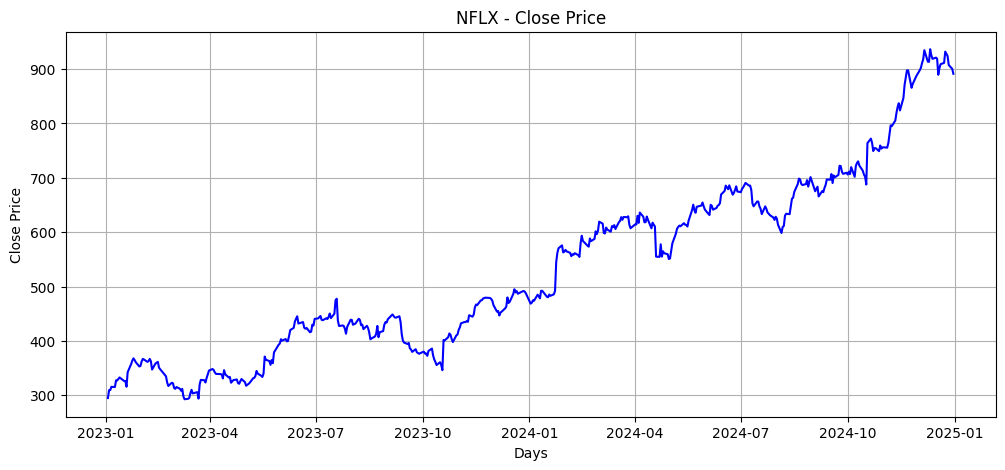

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(data['Close'], color="blue")
plt.title(f'{ticker} - Close Price')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

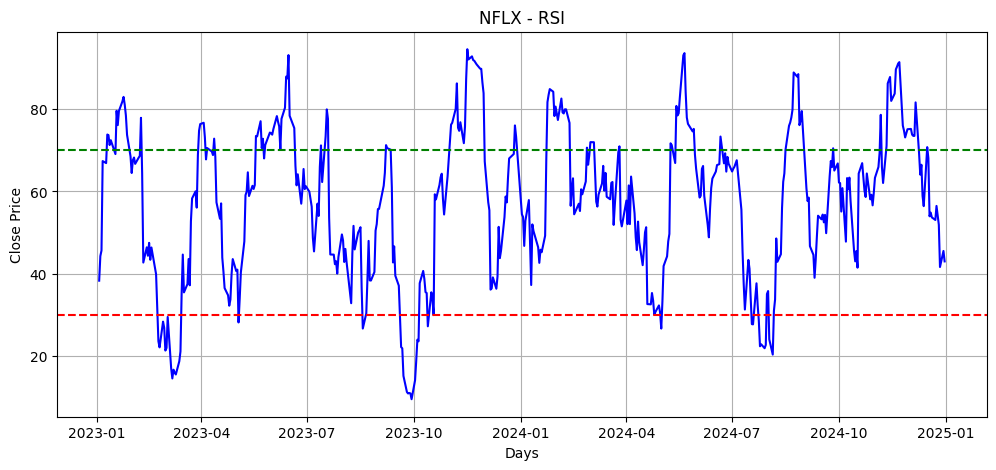

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(data['RSI'], color="blue")
plt.axhline(30, color='red', linestyle='--', label='Oversold (30)')
plt.axhline(70, color='green', linestyle='--', label='Overbought (70)')
plt.title(f'{ticker} - RSI')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

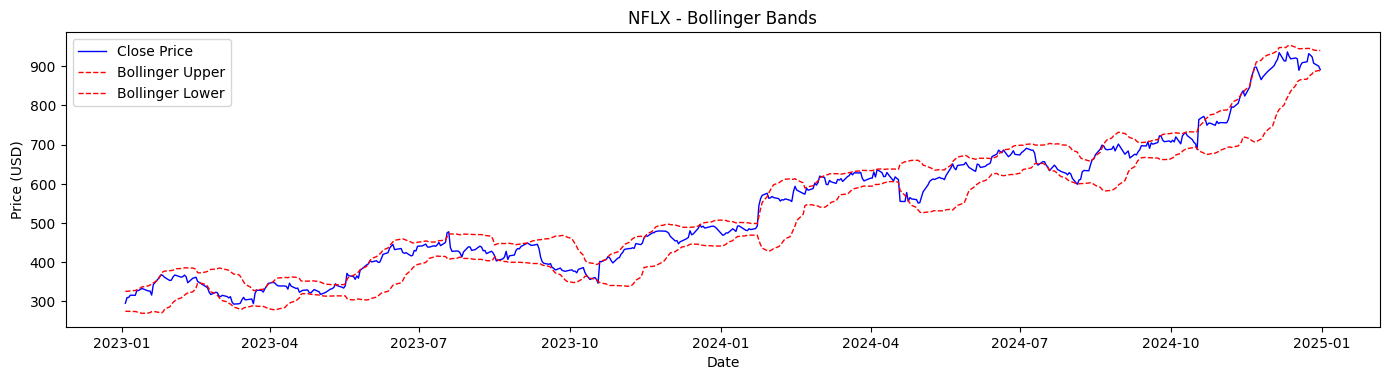

In [16]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price', color='blue', linewidth=1)
plt.plot(data.index, data['Bollinger_Upper'], label='Bollinger Upper', color='red', linestyle='--', linewidth=1)
plt.plot(data.index, data['Bollinger_Lower'], label='Bollinger Lower', color='red', linestyle='--', linewidth=1)
plt.title(f'{ticker} - Bollinger Bands')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()


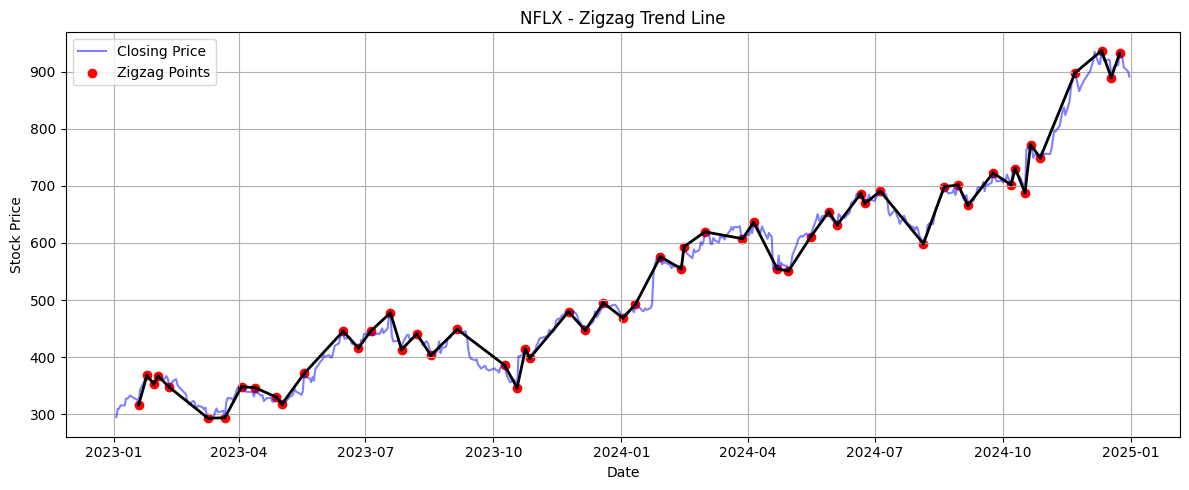

In [17]:
from scipy.signal import argrelextrema
prices = data['Close'].values
# Define the Zigzag indicator
def zigzag_indicator(prices, order=5):
    peaks = argrelextrema(prices, np.greater, order=order)[0]
    valleys = argrelextrema(prices, np.less, order=order)[0]
    zigzag_points = np.sort(np.concatenate((peaks, valleys)))
    return zigzag_points

# Get zigzag points
zigzag_points = zigzag_indicator(prices, order=5)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(data.index, prices, label="Closing Price", color="blue", alpha=0.5)
plt.scatter(data.index[zigzag_points], prices[zigzag_points], color="red", label="Zigzag Points", marker="o")

# Draw straight-line zigzag trend
for i in range(len(zigzag_points) - 1):
    x1 = data.index[zigzag_points[i]]
    x2 = data.index[zigzag_points[i + 1]]
    y1 = prices[zigzag_points[i]]
    y2 = prices[zigzag_points[i + 1]]
    plt.plot([x1, x2], [y1, y2], color="black", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f'{ticker} - Zigzag Trend Line')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

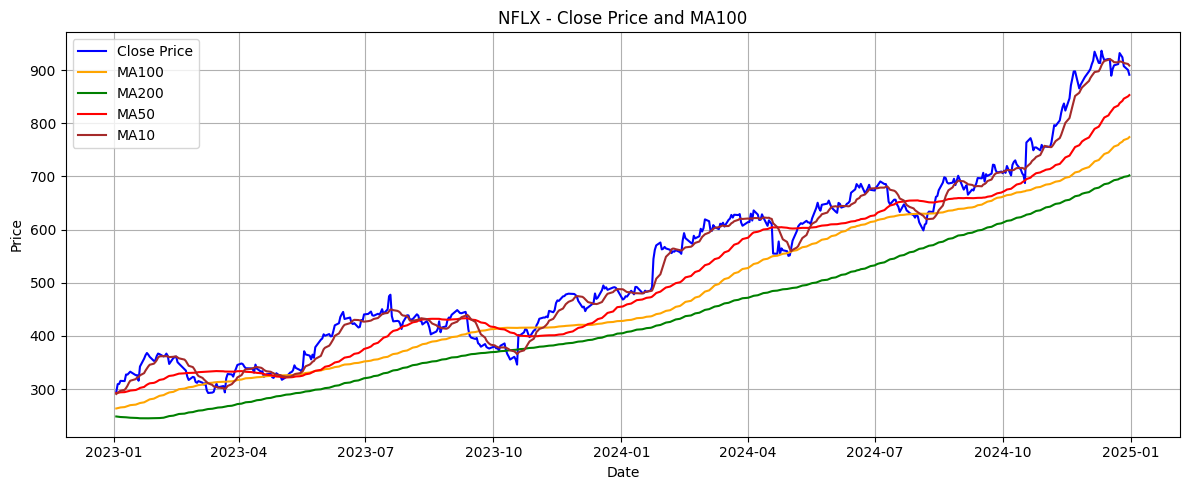

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Close'], label="Close Price", color='blue')
plt.plot(data.index, data['MA100'], label="MA100", color='orange')
plt.plot(data.index, data['MA200'], label="MA200", color='green')
plt.plot(data.index, data['MA50'], label="MA50", color='red')
plt.plot(data.index, data['MA10'], label="MA10", color='brown')

plt.xlabel("Date")  # Change to 'Date' if you set datetime index
plt.ylabel("Price")
plt.title(f'{ticker} - Close Price and MA100')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

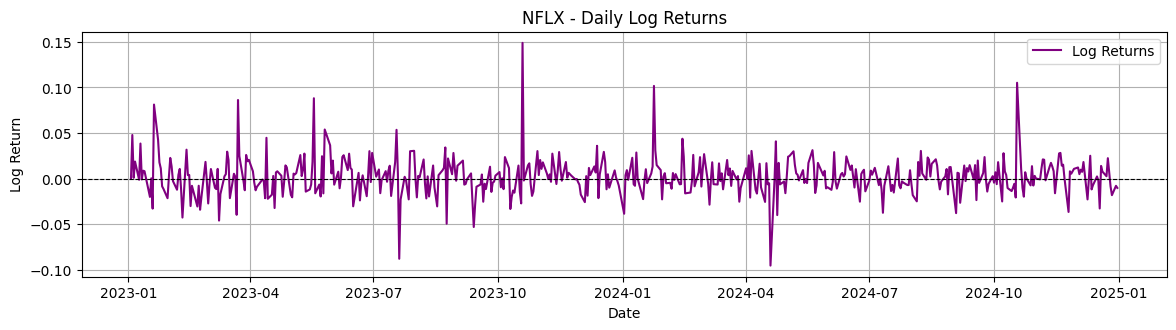

In [19]:
plt.figure(figsize=(14, 7))

# Log Returns
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Log_Returns'], label='Log Returns', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'{ticker} - Daily Log Returns')
plt.xlabel("Date")
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()

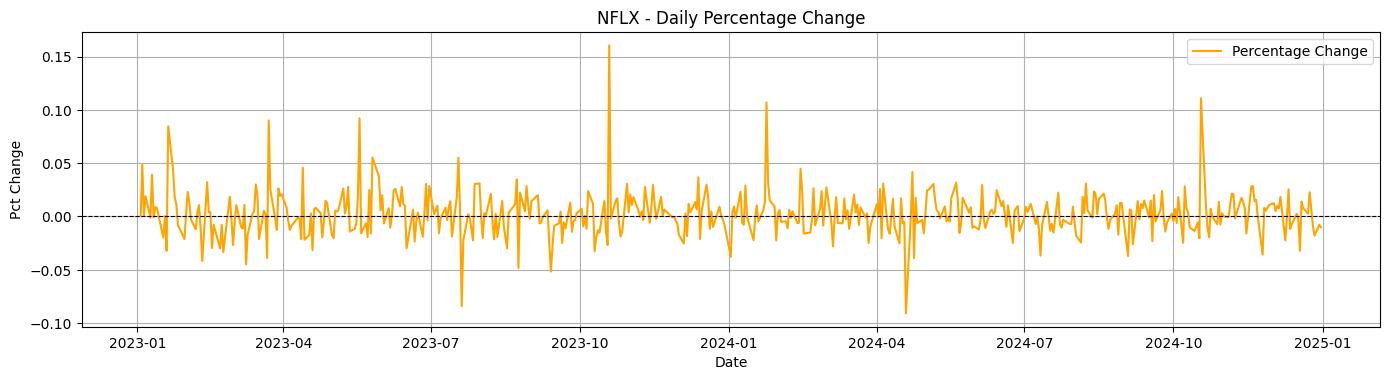

In [20]:
# Percentage Change
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 2)
plt.plot(data.index, data['Pct_Change'], label='Percentage Change', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'{ticker} - Daily Percentage Change')
plt.ylabel('Pct Change')
plt.xlabel('Date')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# -x-x-x-x-x-x-x-x-x-x-x-x- ORIGINAL STOCK SECTORS -x-x-x-x-x-x-x-x-x-x-x-x-


# ['Technology' 'Healthcare' 'Financial Services' 'Real Estate'
#  'Consumer Cyclical' 'Industrials' 'Communication Services'
#  'Consumer Defensive' 'Energy' 'Basic Materials' 'Utilities']
# Basic Materials: ['DOW', 'LIN']
# Communication Services: ['CHTR', 'CMCSA', 'DIS', 'GOOG', 'META', 'NFLX', 'T', 'TMUS', 'VZ']
# Consumer Cyclical: ['AMZN', 'BKNG', 'F', 'GM', 'HD', 'LOW', 'MCD', 'NKE', 'SBUX', 'TSLA']
# Consumer Defensive: ['CL', 'COST', 'KHC', 'KO', 'MDLZ', 'MO', 'PEP', 'PG', 'PM', 'TGT', 'WMT']
# Energy: ['COP', 'CVX', 'XOM']
# Financial Services: ['AIG', 'AXP', 'BAC', 'BK', 'BLK', 'C', 'COF', 'GS', 'JPM', 'MA', 'MET', 'MS', 'PYPL', 'USB', 'V', 'WFC']
# Healthcare: ['ABBV', 'ABT', 'AMGN', 'BMY', 'CVS', 'DHR', 'GILD', 'JNJ', 'LLY', 'MDT', 'MRK', 'PFE', 'TMO', 'UNH', 'WBA']
# Industrials: ['BA', 'CAT', 'EMR', 'FDX', 'GD', 'GE', 'HON', 'LMT', 'MMM', 'RTX', 'UNP', 'UPS']
# Real Estate: ['AMT', 'SPG']
# Technology: ['AAPL', 'ACN', 'ADBE', 'AVGO', 'CRM', 'CSCO', 'IBM', 'INTC', 'INTU', 'MSFT', 'NVDA', 'ORCL', 'QCOM', 'TXN']
# Utilities: ['DUK', 'EXC', 'NEE', 'SO']